In [13]:
%matplotlib widget


In [2]:
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from IPython.display import JSON
import pandas as pd

In [3]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1538_LB_ZF_v552_f5_40fps_1"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

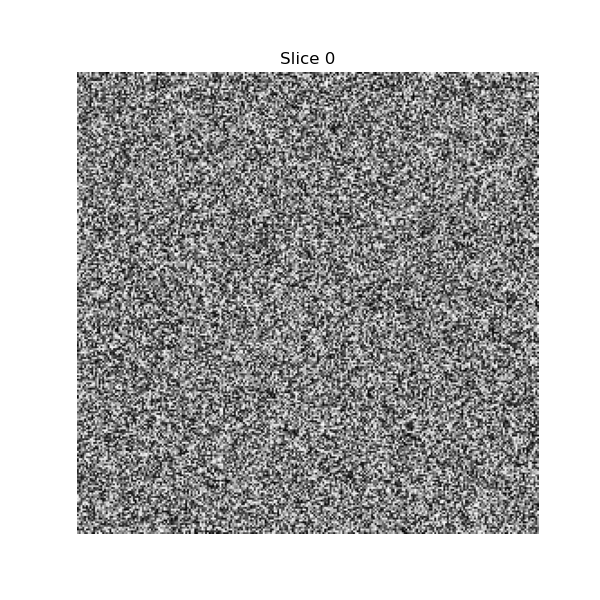

In [14]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, VBox, Output
from IPython.display import display

# Example data
volume = np.random.rand(50, 256, 256)
mask = np.zeros_like(volume, dtype=bool)

current_slice = 0
out = Output()

fig, ax = plt.subplots(figsize=(6,6))
img_handle = ax.imshow(volume[0], cmap='gray')
mask_handle = ax.imshow(np.ma.masked_where(~mask[0], mask[0]), cmap='Reds', alpha=0.5)
ax.set_title(f'Slice 0')
ax.axis('off')

def update_display(z):
    global current_slice
    current_slice = z
    img_handle.set_data(volume[z])
    mask_handle.set_data(np.ma.masked_where(~mask[z], mask[z]))
    ax.set_title(f'Slice {z}')
    fig.canvas.draw_idle()

def on_click(event):
    if event.inaxes != ax:
        return
    x, y = int(event.xdata), int(event.ydata)
    mask[current_slice, y, x] = not mask[current_slice, y, x]
    mask_handle.set_data(np.ma.masked_where(~mask[current_slice], mask[current_slice]))
    fig.canvas.draw_idle()

fig.canvas.mpl_connect('button_press_event', on_click)

slider = IntSlider(min=0, max=volume.shape[0]-1, step=1, value=0, description='Slice')
slider.observe(lambda change: update_display(change['new']), names='value')

display(VBox([slider, out]))
update_display(0)

In [8]:
import matplotlib
print("matplotlib backend:", matplotlib.get_backend())
try:
    import ipympl
    print("ipympl version:", ipympl.__version__)
except ImportError:
    print("ipympl not installed")
try:
    import ipywidgets
    print("ipywidgets version:", ipywidgets.__version__)
except ImportError:
    print("ipywidgets not installed")

matplotlib backend: widget
ipympl version: 0.9.7
ipywidgets version: 8.1.7


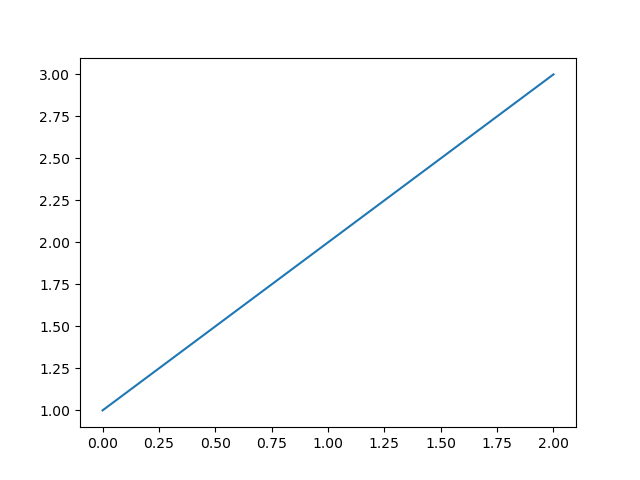

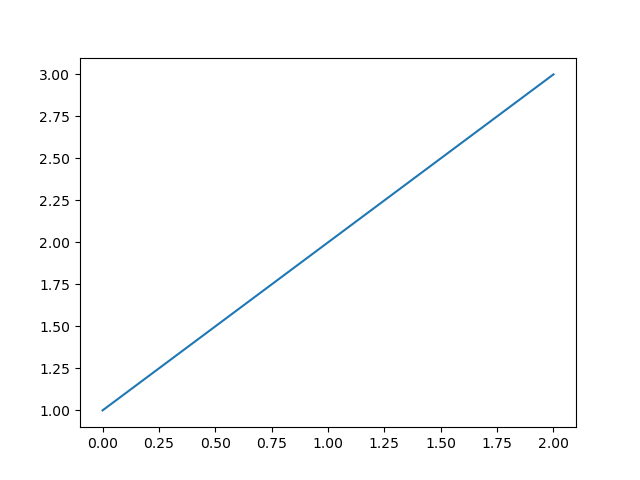

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([1,2,3])
def onclick(event):
    print("Clicked:", event.xdata, event.ydata)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

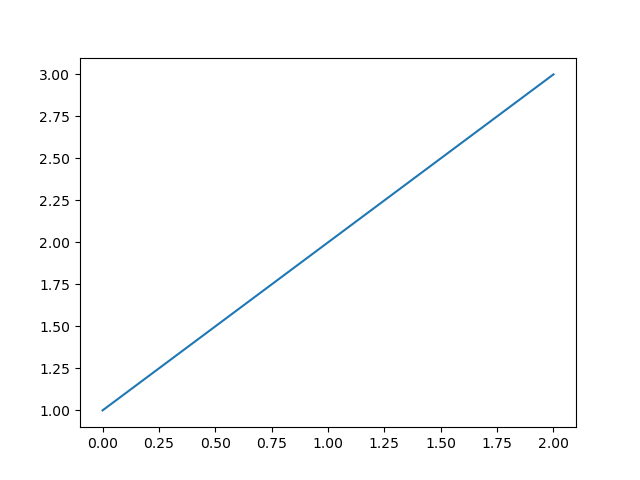

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1,2,3])

def onclick(event):
    print("Clicked:", event.xdata, event.ydata)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [16]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

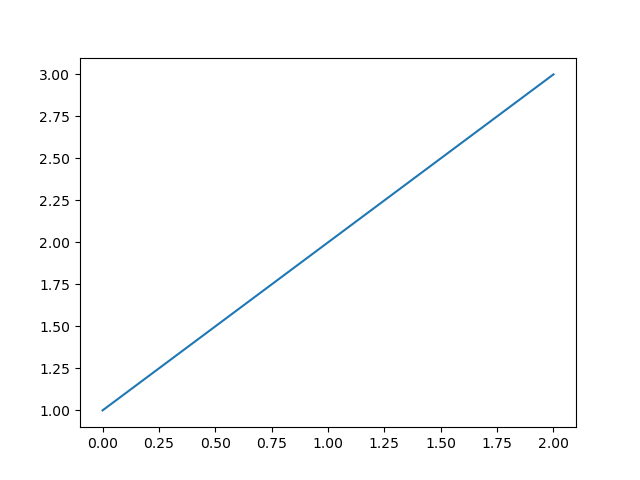

In [17]:
%matplotlib widget
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1,2,3])

def on_any(event):
    print("Event:", event.name, event.xdata, event.ydata)

fig.canvas.mpl_connect('button_press_event', on_any)
fig.canvas.mpl_connect('motion_notify_event', on_any)
plt.show()